## MNIST Handwritten digits classifier

In [1]:
# Import the goodies
%matplotlib inline
%load_ext tensorboard

import numpy as np
import time
import tensorflow as tf
from tensorflow import keras  # import from tensorflow for better support??? I dunno
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [2]:
# Load the data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
# Reshape the data
X = x_train.reshape(60000, 28, 28, 1)
y = y_train.reshape(60000, 1)

# Process the data
X = X / 255.0

# Onehot encode y_train
enc = OneHotEncoder().fit(y)
y = enc.transform(y).toarray()

In [4]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

To find the most ambigious images in the test dataset, we must first build a classifier that gives us the probability of which digit it is

In [5]:
# Build the network

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))  # Filter the data
model.add(layers.MaxPooling2D((2,2)))                                            # Make the view larger; find bigger patterns
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())                                                      # Dimension reduce
model.add(layers.Dropout(0.5))                                                   # Get rid of conspiracies
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))

model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="loss"),  # Stop early if training is only going ok
    tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True, monitor="loss"),
    tf.keras.callbacks.ProgbarLogger(),
#    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]


model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

2021-09-08 11:06:24.830428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

2021-09-08 11:06:24.838105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 11:06:24.838679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 11:06:24.839922: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-08 11:06:24.840518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
# Fit the network
tick = time.time()
history = model.fit(X, y,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0)
#model.save('net1.h5')
print('Took',(time.time()-tick).__round__(4),'seconds to train the network')

2021-09-08 11:06:25.402842: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-08 11:06:26.138064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2021-09-08 11:06:26.989602: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Took 33.7511 seconds to train the network


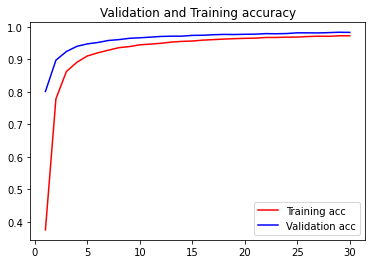

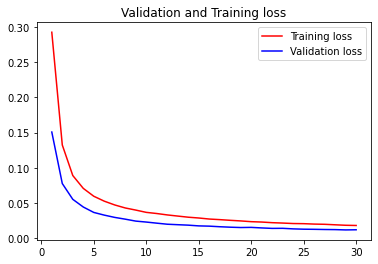

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b-', label='Validation acc')
plt.title('Validation and Training accuracy')
plt.legend()

plt.figure()  # Combines the two graphs

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Validation and Training loss')
plt.legend()

plt.show()

In [8]:
# Test and see how well it classified the data
X_ = x_test.reshape(10000, 28, 28, 1)

X_ = X_ / 255.0

preds = model.predict(X_)

In [9]:
# Find what the model's predictions actually were
summary = np.zeros((10,10))

for p, truth in zip(preds, y_test):
    summary[truth] += p
    #print(p, truth)

row_sums = summary.sum(axis=1)
summary = summary / row_sums[:, np.newaxis]    

<AxesSubplot:>

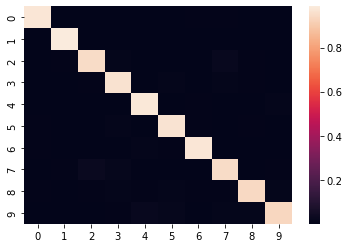

In [10]:
# Add a seaborn plot of 1-10 of classes on each row and how well it classified them
sns.heatmap(summary)

In [11]:
arr = np.vstack((np.arange(0,10000), y_test, preds.argmax(axis=1), np.max(preds, axis=1))).T  
arr   # Columns: Index, Truth, Guess, Confidence

array([[0.00000000e+00, 7.00000000e+00, 7.00000000e+00, 9.99733031e-01],
       [1.00000000e+00, 2.00000000e+00, 2.00000000e+00, 9.99979973e-01],
       [2.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99939680e-01],
       ...,
       [9.99700000e+03, 4.00000000e+00, 4.00000000e+00, 9.99999523e-01],
       [9.99800000e+03, 5.00000000e+00, 5.00000000e+00, 9.98641431e-01],
       [9.99900000e+03, 6.00000000e+00, 6.00000000e+00, 9.99644637e-01]])

In [12]:
# Find the 10 most worst classified datapoints (by its own estimation)
arr = arr[arr[:,3].argsort()]
arr

array([[4.24800000e+03, 2.00000000e+00, 4.00000000e+00, 1.16691858e-01],
       [9.67900000e+03, 6.00000000e+00, 6.00000000e+00, 1.98145241e-01],
       [2.48800000e+03, 2.00000000e+00, 4.00000000e+00, 2.28479385e-01],
       ...,
       [6.97000000e+02, 4.00000000e+00, 4.00000000e+00, 1.00000000e+00],
       [2.38000000e+02, 4.00000000e+00, 4.00000000e+00, 1.00000000e+00],
       [8.67500000e+03, 4.00000000e+00, 4.00000000e+00, 1.00000000e+00]])

Create a heatmap of these bad classifications

In [13]:
arr[:10]

array([[4.24800000e+03, 2.00000000e+00, 4.00000000e+00, 1.16691858e-01],
       [9.67900000e+03, 6.00000000e+00, 6.00000000e+00, 1.98145241e-01],
       [2.48800000e+03, 2.00000000e+00, 4.00000000e+00, 2.28479385e-01],
       [7.21600000e+03, 0.00000000e+00, 6.00000000e+00, 2.50507116e-01],
       [6.55800000e+03, 6.00000000e+00, 5.00000000e+00, 2.54424483e-01],
       [1.41400000e+03, 9.00000000e+00, 5.00000000e+00, 2.60238349e-01],
       [3.77800000e+03, 5.00000000e+00, 0.00000000e+00, 2.65057653e-01],
       [2.11800000e+03, 6.00000000e+00, 4.00000000e+00, 2.73076832e-01],
       [3.06200000e+03, 8.00000000e+00, 2.00000000e+00, 2.77831972e-01],
       [6.59000000e+02, 2.00000000e+00, 1.00000000e+00, 3.00561458e-01]])

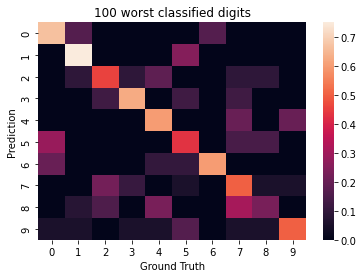

In [14]:
# Amount to show
n = 100
heat = np.zeros((10,10))

for i, truth, guess, con in arr[:n]:
    heat[int(truth), int(guess)] += 1

row_sums = heat.sum(axis=1)
heat = heat / row_sums[:, np.newaxis] 

ax = plt.axes()
sns.heatmap(heat, ax=ax)
ax.set_title(f'{n} worst classified digits')
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()

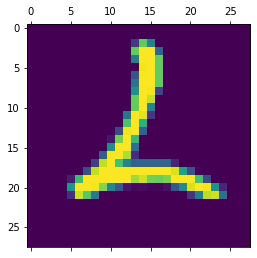

In [15]:
x_test[4248].shape
plt.matshow(x_test[326])
plt.show()

In [16]:
arr[:, 0][:10].astype('int')

array([4248, 9679, 2488, 7216, 6558, 1414, 3778, 2118, 3062,  659])

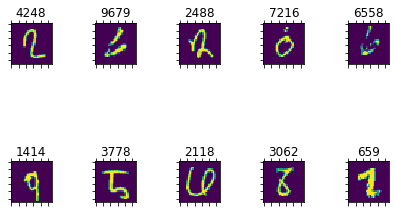

In [17]:
cols = 5
rows = 2

to_plot = arr[:, 0][:10].astype('int')

fig, axs = plt.subplots(rows, cols)
fig.tight_layout()

cnt = 0
for i in range(rows):
    for j in range(cols):
        axs[i,j].matshow(x_test[to_plot[cnt]])
        axs[i, j].set_title(f'{to_plot[cnt]}')
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        cnt += 1

plt.show()